## Parameters

In [1]:
# Directory for input image:
indir = '../data/outputs/lab2im/brains/'

# Selected image from the input directory
selected = 0

# Directory for output data:
outdir = '../data/outputs/baseline_registration/'

#Spacing of input image: 
spacing = (0.025,0.025,0.025)

# Orientation of input image (rotation will be applied if it's not the same as atlas):
ORIENTATION = 'asr'

# Needed if only one hemisphere is present in image:
HALF_BRAIN = False 
HEMISPHERE = [] # put in 'l' or 'r' in order 

# Use Dask when memory is too low to load image
USE_DASK = False
#USE_DASK = True

# Parameters for Registration:
iterations_TRSAA = (40,20,10)
iterations_SyN = (400,200,100)
aff_iterations=(2100, 1200, 1200, 400)
intensity_power_exponent = 0.5

# For when registration seems poor due to size difference between brain and atlas:
tuned_spacing = (0.025,0.025,0.025) #spacing for atlas used by registration, decrease in squished dimentions for better registration


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import ants
import matplotlib.pyplot as plt
import os
import sys
import h5py
import bg_space as bg
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
import time
import nibabel as nib
import scipy

In [3]:
# Check if output directory exists, create it if not
if os.path.isdir(outdir):
    print("Found {}".format(outdir))
else:
    print("Creating {}".format(outdir))
    
    os.makedirs(outdir)

Found ../data/outputs/baseline_registration/


## List Nifti Files in input directory

In [4]:
candidates = [ f for f in sorted(os.listdir(indir),key=str.casefold) if f.endswith('.nii.gz') ]

for i,f in enumerate(candidates):
    print('[{}] {}'.format(i,f))

[0] brain_00.nii.gz
[1] brain_01.nii.gz
[2] brain_02.nii.gz
[3] brain_03.nii.gz
[4] brain_04.nii.gz
[5] brain_05.nii.gz
[6] brain_06.nii.gz
[7] brain_07.nii.gz
[8] brain_08.nii.gz
[9] brain_09.nii.gz
[10] normalized_brain_00.nii.gz
[11] normalized_brain_01.nii.gz
[12] normalized_brain_02.nii.gz
[13] normalized_brain_03.nii.gz
[14] normalized_brain_04.nii.gz
[15] normalized_brain_05.nii.gz
[16] normalized_brain_06.nii.gz
[17] normalized_brain_07.nii.gz
[18] normalized_brain_08.nii.gz
[19] normalized_brain_09.nii.gz


## Read selected Nifti image, change the variable 'selected' if necessary.

In [7]:
inpath = os.path.join(indir,candidates[selected])
img_nib = nib.load(inpath)
img = img_nib.get_fdata()

DATASET_NAME = candidates[selected][:-7]

print(DATASET_NAME)
print(img.shape)
print(spacing)

normalized_brain_00
(528, 320, 456)
(0.025, 0.025, 0.025)


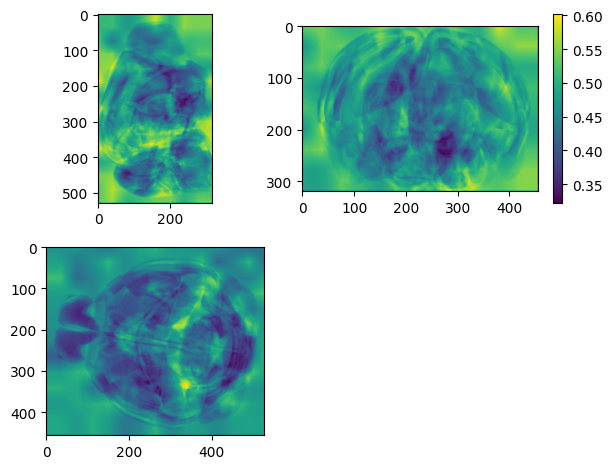

In [30]:
# Function to show projections of a volume
def showProjections(volume, **kwargs):
    f, ax = plt.subplots(2, 2, **kwargs)
    
    volumexy = volume.mean(axis=2)
    volumexz = volume.mean(axis=1)
    volumeyz = volume.mean(axis=0)
    
    im1 = ax[0, 0].imshow(volumexy)
    im2 = ax[0, 1].imshow(volumeyz)
    im3 = ax[1, 0].imshow(volumexz.T)
    ax[1, 1].axis('off')

    plt.tight_layout()
    
    return im1, im2, im3

im1, im2, im3 = showProjections(img)
plt.colorbar(im2)
plt.show()

## Read and Process Atlas:

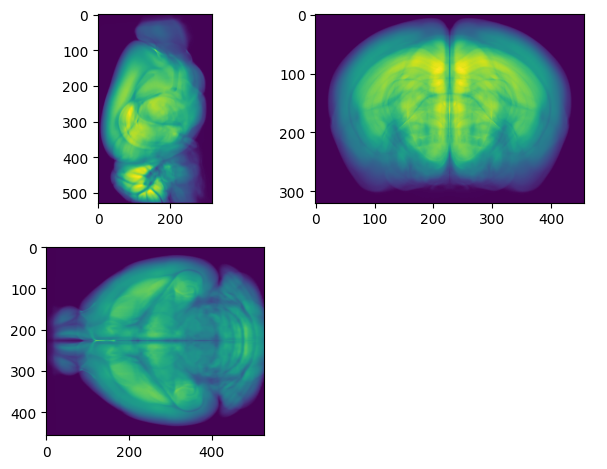

In [13]:
atlas = BrainGlobeAtlas("kim_mouse_25um")
#atlas.hemispheres: 1 in left, 2 in right

reference_image = atlas.reference.copy()

#showProjections(atlas.reference,figsize=(15,15)) 
#plt.show()


# Select hemisphere if only one is present in the image
if HALF_BRAIN:
    where_1 = np.where(atlas.hemispheres == 1)
    where_2 = np.where(atlas.hemispheres == 2)
    if HEMISPHERE[selected] == 'l':
        reference_image[where_2] = 0
    elif HEMISPHERE[selected] == 'r':
        reference_image[where_1] = 0
    else:
        print('NO HEMISPHERE SET!')

showProjections(reference_image)  
plt.show()

## Rotate image to atlas orientation if not already:

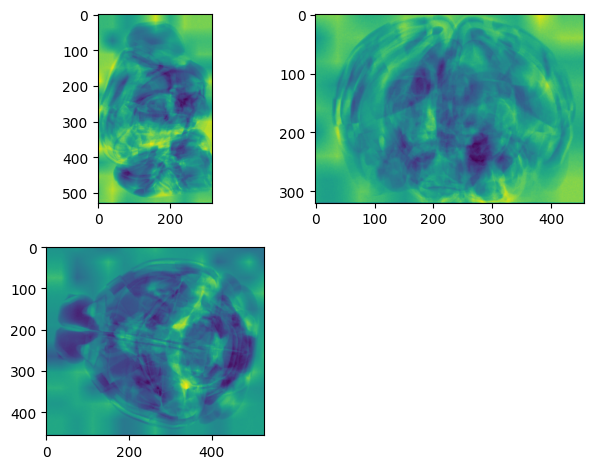

In [14]:
source_origin = ORIENTATION
target_origin = (atlas.orientation)

source_space = bg.AnatomicalSpace(source_origin, img.shape)
mapped_image = source_space.map_stack_to(target_origin, img)

showProjections(mapped_image)  
plt.show()

## Read image into Antspy, downsample Image for registration if needed:

In [15]:
mapped_image[mapped_image==2**16-1]=0          #used to account for stitching issues in previous versions

im_A = ants.from_numpy(data=mapped_image.astype('float'),spacing=spacing,direction=np.eye(3))

In [16]:
im_A

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [17]:
spacing_25 = tuple([ max(m,0.025) for m in spacing ])

spacing_25

(0.025, 0.025, 0.025)

In [18]:
start = time.time()
#im_A_25 = im_A.resample_image(spacing_25,interp_type=0)
im_A_25 = im_A
end = time.time()
print(end - start)

6.699562072753906e-05


## Mode subtraction

In [19]:
bkg, Npx = scipy.stats.mode(im_A_25.numpy(), axis=None)
bkg=bkg[0]

print(bkg)

/tmp/ipykernel_1993882/1475849720.py:1: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



0.5062028


In [20]:
volumeCorr = np.clip(im_A_25.numpy().astype('float') - bkg,a_min=0,a_max=None)

im_A_25[:] = volumeCorr[:]

# Registration

In [21]:
fixed = im_A_25.copy()
moving = ants.from_numpy(data=reference_image.astype('float'),spacing=tuned_spacing,direction=np.eye(3))    #if spacing here is changed, scaling for point coor. has to be changed too!
fixed_02 = fixed**intensity_power_exponent

In [22]:
fixed

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [46]:
#ants.image_write(fixed,'/mnt/e/tests/img_before_tx.nii')
#ants.image_write(moving,'/mnt/e/tests/atlas.nii')

216.6059648990631
{'warpedmovout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'warpedfixout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'fwdtransforms': ['/tmp/tmpo72agrnc0GenericAffine.mat'], 'invtransforms': ['/tmp/tmpo72agrnc0GenericAffine.mat']}


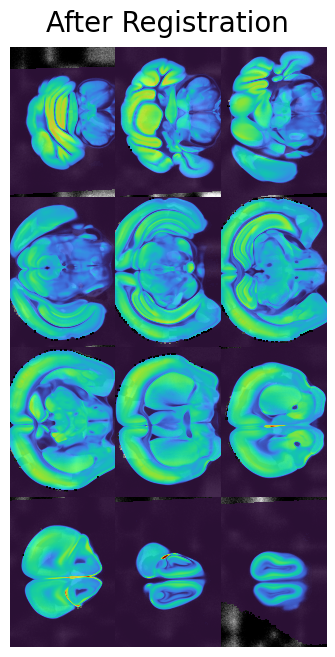

In [47]:
start = time.time()
mytx_TRSAA = ants.registration(
    fixed=fixed_02,
    moving=moving,
    type_of_transform='TRSAA',
    reg_iterations=iterations_TRSAA,
    aff_iterations = aff_iterations,
    verbose=False)

end = time.time()
print('TRSAA Registration time' + end - start, 'seconds')

print(mytx_TRSAA)
warped_moving = mytx_TRSAA['warpedmovout']
fixed.plot(overlay=warped_moving,
           title='After Registration')

#mytx_TRSAA['fwdtransforms']


In [48]:
ants.image_write(mytx_TRSAA['warpedfixout'], os.path.join(outdir,DATASET_NAME) + 'img_after_TRSAA.nii')

2999.505068063736
{'warpedmovout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'warpedfixout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'fwdtransforms': ['/tmp/tmp_ldfs9ct1Warp.nii.gz', '/tmp/tmp_ldfs9ct0GenericAffine.mat'], 'invtransforms': ['/tmp/tmp_ldfs9ct0GenericAffine.mat', '/tmp/tmp_ldfs9ct1InverseWarp.nii.gz']}


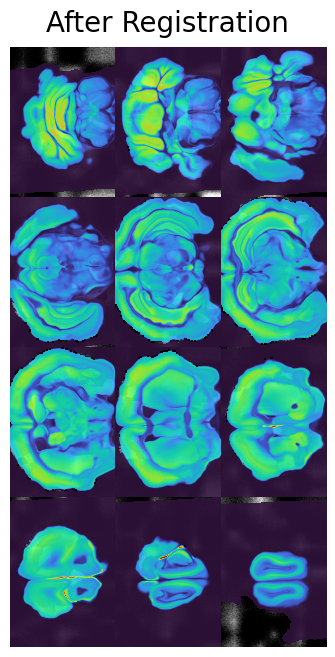

In [49]:
# Takes 1 hour
start = time.time()

mytx = ants.registration(
    fixed=fixed_02,
    moving=moving,
    initial_transform=mytx_TRSAA['fwdtransforms'][0],
    type_of_transform='SyN',
    reg_iterations=iterations_SyN,
    verbose=False )

end = time.time()
print(end - start)

registration_time = end - start

print("Registration time:", registration_time, "seconds")


print(mytx)
warped_moving = mytx['warpedmovout']
fixed.plot(overlay=warped_moving,
           title='After Registration')

In [50]:
#ants.image_write(mytx['warpedfixout'],'/mnt/e/tests/img_after_SyN.nii')

## Generate warped image

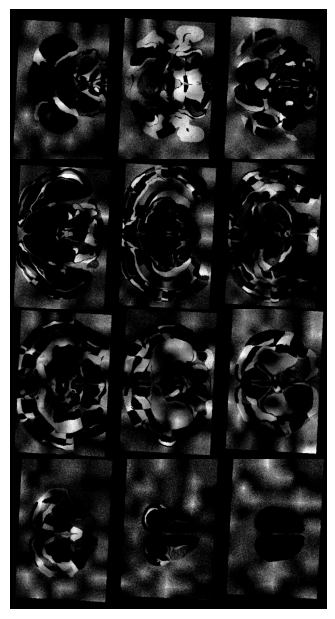

In [51]:
mywarpedimage = ants.apply_transforms(fixed=moving, moving=fixed,interpolator='nearestNeighbor',
                                      transformlist=mytx['invtransforms'])

mywarpedimage.plot()

In [52]:
if os.path.isdir(outdir):
    print("Found {}".format(outdir))
else:
    print("Creating {}".format(outdir))
    
    os.makedirs(outdir)

Found ../data/outputs/baseline_registration/


In [53]:
ants.image_write(mywarpedimage,os.path.join(outdir, DATASET_NAME) + '_warped_image_atlasSpace.nii')

In [54]:
#ants.image_write(im_A,'/mnt/e/tests/im_A.nii')

In [55]:
# read annotation image into ants format
annotation_image = atlas.annotation.copy()
annotation_A = ants.from_numpy(data=annotation_image.astype('float'),spacing=tuned_spacing,direction=np.eye(3))

# Apply forward transform to reference
warped_reference = ants.apply_transforms(fixed=fixed, moving=moving,interpolator='nearestNeighbor',
                                      transformlist=mytx['fwdtransforms'])

# Apply forward transform to annotation
warped_annotation = ants.apply_transforms(fixed=fixed, moving=annotation_A,interpolator='nearestNeighbor',
                                      transformlist=mytx['fwdtransforms'])

# Save both to output
ants.image_write(warped_reference,os.path.join(outdir,DATASET_NAME) + '_warped_reference_imageSpace.nii')
ants.image_write(warped_annotation,os.path.join(outdir,DATASET_NAME) + '_warped_annotation_imageSpace.nii')

# Generate transforms from registration

In [56]:
mytx['fwdtransforms']

['/tmp/tmp_ldfs9ct1Warp.nii.gz', '/tmp/tmp_ldfs9ct0GenericAffine.mat']

In [57]:
affine_tx = ants.read_transform(mytx['fwdtransforms'][1])
deformation_im = ants.image_read(mytx['fwdtransforms'][0])

In [58]:
ants.write_transform(affine_tx, os.path.join(outdir,DATASET_NAME) + '_affine_tx.nii')
ants.image_write(deformation_im, os.path.join(outdir,DATASET_NAME) + '_deformation_tx.nii')